<a href="https://colab.research.google.com/github/Dau2004/Weather_Classifier_App/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries
Import necessary libraries for data processing, model building, training, and visualization.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import math

# Set Paths and Hyperparameters
Define dataset paths and model hyperparameters.

In [2]:
# Loading data
train_dir = '/content/drive/MyDrive/indabax-south-sudan/weather_dataset'
test_dir = '/content/drive/MyDrive/indabax-south-sudan/weather_dataset'


# Exploratory data analysis and Data Preprocessing

In [6]:
# Check the contents of the train and test directories
print("Training directory contents:", os.listdir(train_dir))
print("Testing directory contents:", os.listdir(test_dir))

Training directory contents: ['Rain', 'Cloudy', 'Sunrise', 'Shine']
Testing directory contents: ['Rain', 'Cloudy', 'Sunrise', 'Shine']


In [8]:
# List the classes
train_classes = os.listdir(train_dir)
test_classes = os.listdir(test_dir)

print("Training classes:", train_classes)
print("Testing classes:", test_classes)


Training classes: ['Rain', 'Cloudy', 'Sunrise', 'Shine']
Testing classes: ['Rain', 'Cloudy', 'Sunrise', 'Shine']


In [9]:
# Count the number of images in each class for training
train_counts = {}
for cls in train_classes:
  train_counts[cls] = len(os.listdir(os.path.join(train_dir, cls)))

print("Training image counts per class:", train_counts)

Training image counts per class: {'Rain': 215, 'Cloudy': 300, 'Sunrise': 357, 'Shine': 253}


In [10]:
# Count the number of images in each class for testing
test_counts = {}
for cls in test_classes:
  test_counts[cls] = len(os.listdir(os.path.join(test_dir, cls)))

print("Testing image counts per class:", test_counts)


Testing image counts per class: {'Rain': 215, 'Cloudy': 300, 'Sunrise': 357, 'Shine': 253}


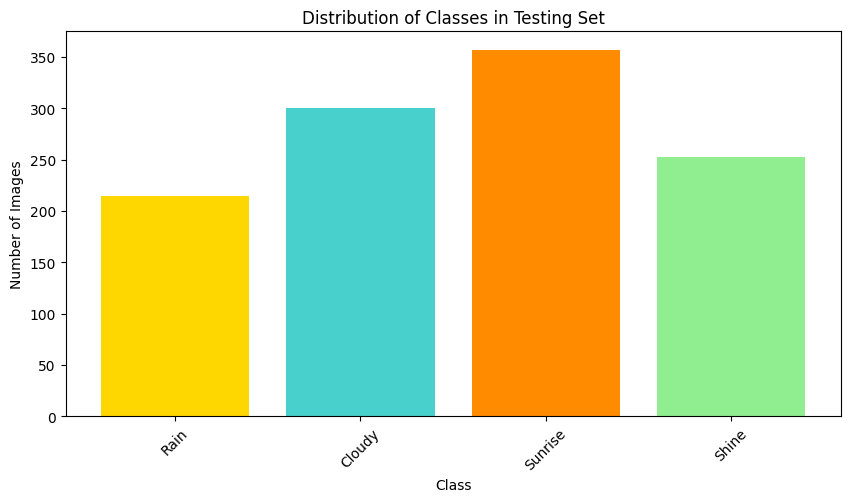

In [17]:
# Visualize the distribution of classes in the testing set
plt.figure(figsize=(10, 5))
# Define the color mapping
color_map = {'Rain': 'gold', 'Cloudy': 'mediumturquoise', 'Sunrise': 'darkorange', 'Shine': 'lightgreen'}
# Get the colors in the order of the test_counts keys
bar_colors = [color_map[cls] for cls in test_counts.keys()]
plt.bar(test_counts.keys(), test_counts.values(), color=bar_colors)
plt.title("Distribution of Classes in Testing Set")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

In [16]:
#Population Distribution of Data:

import plotly.express as px
images_population = train_counts # assuming images_population was meant to be train_counts
df = pd.DataFrame.from_dict({'Name':[i for i in images_population.keys()],'#Images':[i for i in images_population.values()]})
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
# Ensure the order of colors matches the order of names in the DataFrame
color_map = {'Rain': 'gold', 'Cloudy': 'mediumturquoise', 'Sunrise': 'darkorange', 'Shine': 'lightgreen'}
df['Color'] = df['Name'].map(color_map)

fig = px.pie(df,values='#Images',names='Name', hole=.3, width=600, height=600,opacity=.80,
             color='Name', # Specify color based on 'Name' column
             color_discrete_map=color_map) # Map 'Name' to specific colors

fig.update_traces(hoverinfo='label+percent',textfont_size=20, marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide', title={'text': 'Population of Various Classes','y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.show()

In [5]:


# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS_PHASE1 = 15
EPOCHS_PHASE2 = 100
NUM_CLASSES = len(os.listdir(train_dir))


Number of classes: 4
Classes: ['Rain', 'Cloudy', 'Sunrise', 'Shine']
Number of images per class: {'Rain': 215, 'Cloudy': 300, 'Sunrise': 357, 'Shine': 253}


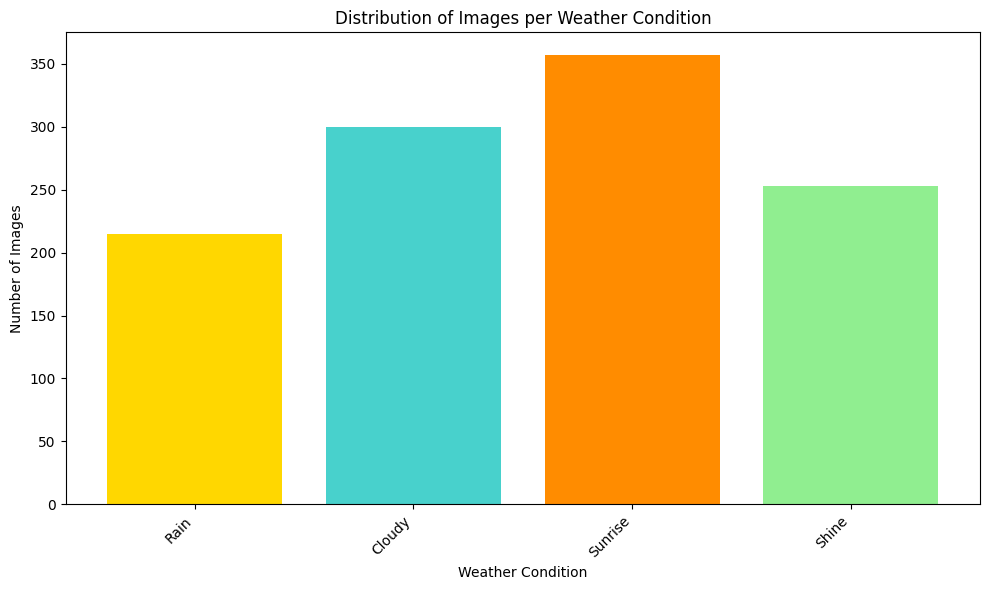

In [21]:
# exploratory data analysis

print("Number of classes:", NUM_CLASSES)
print("Classes:", os.listdir(train_dir))

# Count number of images in each class
class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

print("Number of images per class:", class_counts)

# Plot class distribution
plt.figure(figsize=(10, 6))
# Define the color mapping
color_map = {'Rain': 'gold', 'Cloudy': 'mediumturquoise', 'Sunrise': 'darkorange', 'Shine': 'lightgreen'}
# Get the colors in the order of the class_counts keys
bar_colors = [color_map[cls] for cls in class_counts.keys()]
plt.bar(class_counts.keys(), class_counts.values(), color=bar_colors)
plt.xlabel("Weather Condition")
plt.ylabel("Number of Images")
plt.title("Distribution of Images per Weather Condition")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Displaying images from class: Rain


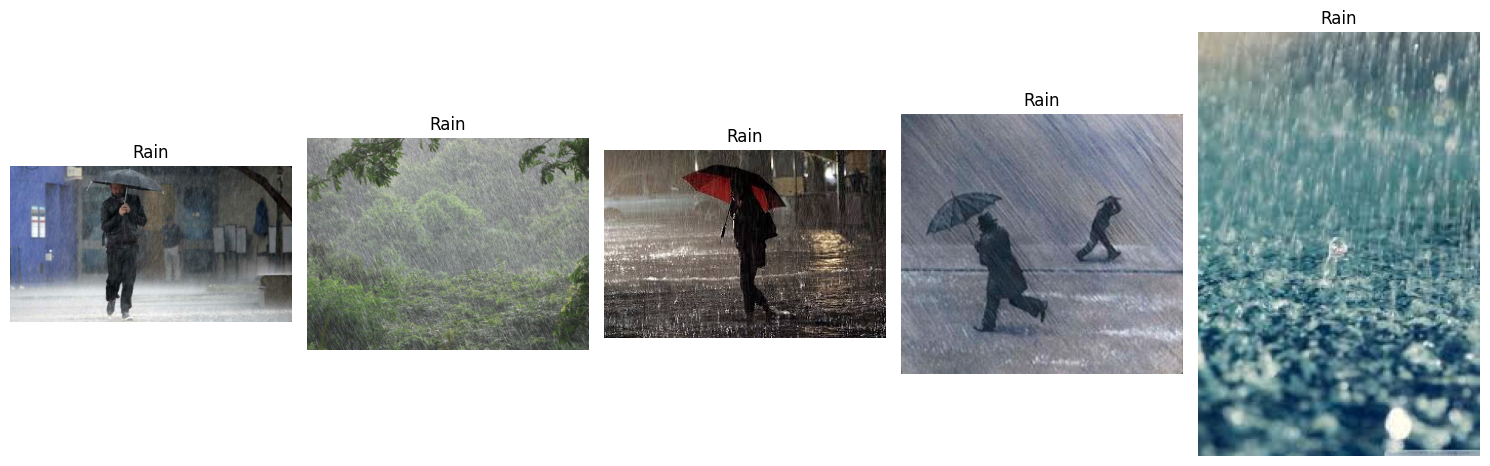

Displaying images from class: Cloudy


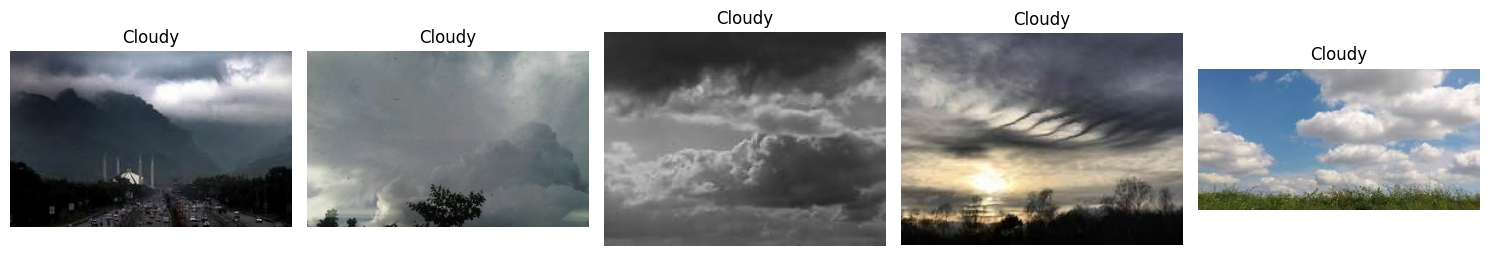

Displaying images from class: Sunrise


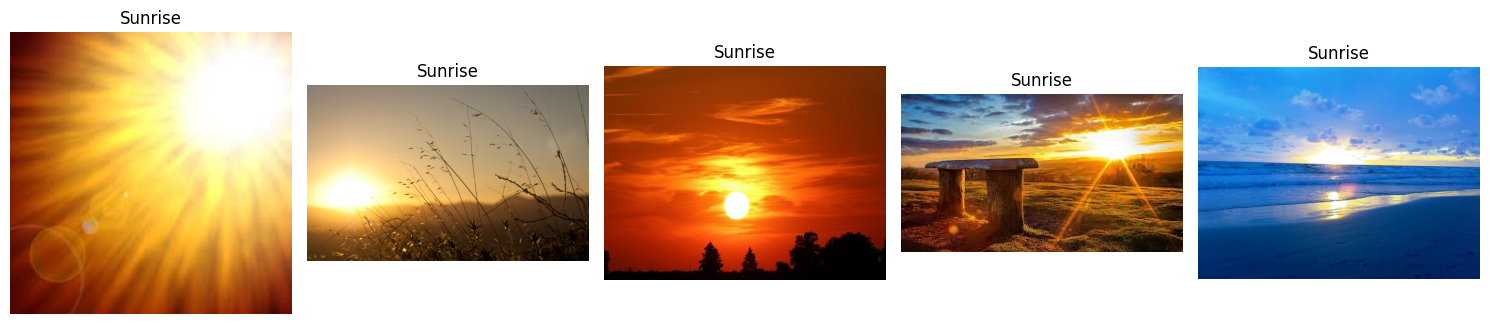

Displaying images from class: Shine


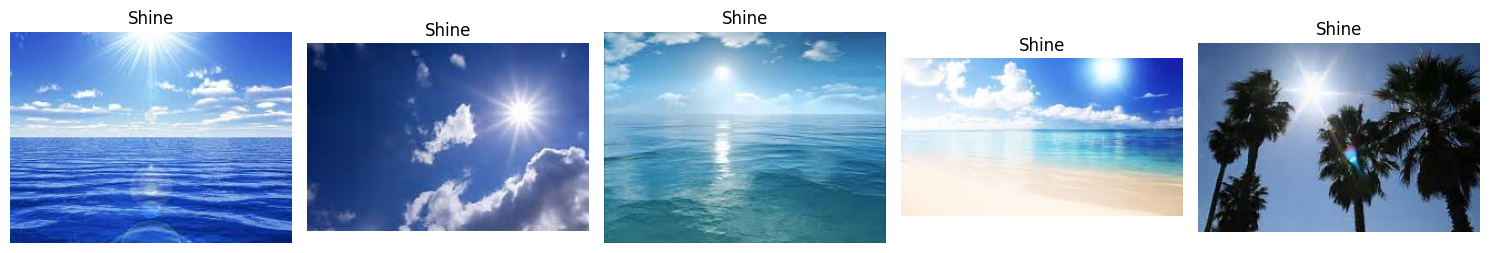

Number of test images: 4


In [20]:
# Visualize a few images from each class
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        print(f"Displaying images from class: {class_name}")
        image_files = os.listdir(class_path)[:5] # Display up to 5 images
        plt.figure(figsize=(15, 5))
        for i, img_file in enumerate(image_files):
            img_path = os.path.join(class_path, img_file)
            img = plt.imread(img_path)
            plt.subplot(1, 5, i + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

# Check the number of test images
if os.path.exists(test_dir):
    print("Number of test images:", len(os.listdir(test_dir)))
else:
    print("Test directory not found.")

#Data Augmentation
Prepare data generators for training and validation with image augmentation.

In [22]:
# --- Data Generators with More Robust Augmentation ---
datagen_train = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.5, 1.5],
    channel_shift_range=70,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen_val.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 901 images belonging to 4 classes.
Found 224 images belonging to 4 classes.


#Build the Model
Define a function that builds and returns a MobileNetV2-based model.

In [23]:

# --- Function to Build and Compile the Model (for Ensembling) ---
def build_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.6)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.inputs, outputs=output)

    return model, base_model

# Define Cosine Annealing Scheduler
Used to adjust the learning rate dynamically during training.

In [24]:
# --- Cosine Annealing Learning Rate Scheduler ---
def cosine_annealing_lr(epoch, lr_start, total_epochs, warmup_epochs=5): # Added warmup_epochs parameter
    if epoch < warmup_epochs:
        lr = lr_start * (epoch / warmup_epochs) if warmup_epochs > 0 else lr_start # Avoid division by zero
    else:
        progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        lr = lr_start * 0.5 * (1 + math.cos(math.pi * progress))
    return lr

#Train Multiple Models for Ensembling
Train multiple instances of the model using a 2-phase strategy.

In [ ]:
# --- Ensembling Parameters ---
NUM_MODELS_TO_ENSEMBLE = 3
trained_model_paths = []

# Store histories for plotting all later if desired
all_phase1_histories = []
all_phase2_histories = []

for i in range(NUM_MODELS_TO_ENSEMBLE):
    model, base_model = build_model()
    model_save_path = f'best_model_ensemble_{i+1}.keras'
    trained_model_paths.append(model_save_path)

    # Phase 1: Train only the head
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
    callbacks_p1 = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint(f'best_model_phase1_model_{i+1}.keras', monitor='val_accuracy', save_best_only=True)
    ]
    history_p1 = model.fit(train_generator, epochs=EPOCHS_PHASE1, validation_data=val_generator, callbacks=callbacks_p1)
    all_phase1_histories.append(history_p1.history)
    model.load_weights(f'best_model_phase1_model_{i+1}.keras')

    # Phase 2: Fine-tune base model
    for layer in base_model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
    phase2_lr_start = 0.00001
    lr_scheduler_p2 = LearningRateScheduler(lambda epoch: cosine_annealing_lr(epoch, lr_start=phase2_lr_start, total_epochs=EPOCHS_PHASE2))
    model.compile(optimizer=Adam(phase2_lr_start), loss='categorical_crossentropy', metrics=['accuracy'])
    callbacks_p2 = [lr_scheduler_p2, EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True), ModelCheckpoint(model_save_path, monitor='val_accuracy', save_best_only=True)]
    history_p2 = model.fit(train_generator, epochs=EPOCHS_PHASE2, validation_data=val_generator, callbacks=callbacks_p2)
    all_phase2_histories.append(history_p2.history)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_162']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 893ms/step - accuracy: 0.5585 - loss: 1.3254 - val_accuracy: 0.7545 - val_loss: 0.5515 - learning_rate: 5.0000e-04
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 644ms/step - accuracy: 0.8755 - loss: 0.3813 - val_accuracy: 0.7991 - val_loss: 0.4570 - learning_rate: 5.0000e-04
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 604ms/step - accuracy: 0.8961 - loss: 0.3522 - val_accuracy: 0.8214 - val_loss: 0.4044 - learning_rate: 5.0000e-04
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 612ms/step - accuracy: 0.8838 - loss: 0.3236 - val_accuracy: 0.8616 - val_loss: 0.3428 - learning_rate: 5.0000e-04
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 635ms/step - accuracy: 0.9105 - loss: 0.2862 - val_accuracy: 0.8616 - val_loss: 0.3376 - learning_rate: 5.0000e-04
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 577ms/step - accuracy: 0.8869 - loss: 0.3679 - val_accuracy: 0.8571 - val_loss: 0.3329 - learning_rate: 5.0000e-04
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 579ms/step - accuracy: 0.88

#Ensemble Prediction with Test-Time Augmentation
Perform predictions with all models using TTA for robustness.

In [ ]:



# --- Load all trained models and perform TTA for Ensembling ---
print("\nLoading trained models for ensembled prediction...")
ensemble_models = [load_model(path) for path in trained_model_paths]

# --- Test-Time Augmentation (TTA) for Ensembled Prediction ---
test_datagen_tta = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

# Collect all image file paths from the test directory and its subfolders
test_image_paths = []
for root, _, files in os.walk(test_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            test_image_paths.append(os.path.join(root, file))

# --- IMPORTANT: Sort the test image paths to ensure consistent order ---
test_image_paths.sort()

# --- Verify Test Image Count (Crucial for Kaggle) ---
expected_test_images = 226
if len(test_image_paths) != expected_test_images:
    print(f"ERROR: Expected {expected_test_images} test images, but found {len(test_image_paths)}. This will likely cause submission issues.")
    # Consider adding `raise ValueError("Incorrect number of test images.")` here to stop execution
    # if the count is critical and must be exact.

# Create a dataframe with the collected file paths
test_df = pd.DataFrame({'filename': test_image_paths})

print(f"\n🧪 Predicting on Test Set with Ensembled Models and Test-Time Augmentation (TTA)...")
N_TTA_ENSEMBLE = 15 # Increased TTA count further

all_ensemble_preds = []

for m_idx, current_model in enumerate(ensemble_models):
    print(f"  Predicting with Model {m_idx+1}/{NUM_MODELS_TO_ENSEMBLE}...")
    model_tta_preds = []
    for i in range(N_TTA_ENSEMBLE):
        current_test_generator = test_datagen_tta.flow_from_dataframe(
            test_df,
            x_col='filename',
            y_col=None,
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            class_mode=None,
            shuffle=False
        )
        current_test_generator.reset()
        preds = current_model.predict(current_test_generator, steps=len(current_test_generator), verbose=0)
        model_tta_preds.append(preds)

    avg_model_preds = np.mean(model_tta_preds, axis=0)
    all_ensemble_preds.append(avg_model_preds)

avg_ensemble_preds = np.mean(all_ensemble_preds, axis=0)
y_pred = np.argmax(avg_ensemble_preds, axis=1)

# Submission File

In [ ]:
# Map predictions to labels
label_to_class = {v: k for k, v in train_generator.class_indices.items()}
predicted_labels = [label_to_class[i] for i in y_pred]

# 📤 Prepare Submission File - THIS IS THE MOST LIKELY FIX FOR ID MISMATCH
submission = pd.DataFrame({
    'id': range(1, len(predicted_labels) + 1), # <-- Use sequential IDs
    'label': predicted_labels
})

submission.to_csv('submission_enhanced.csv', index=False)

print("✅ Enhanced Submission file created successfully!")



# Plot Combined Training History
Visualize training and validation metrics from both training phases.

Found 901 images belonging to 4 classes.
Found 224 images belonging to 4 classes.
Starting training for 3 models for ensembling...

✨ Training Model 1/3 ✨
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
🚀 Starting Phase 1 for Model 1: Initial training with frozen base layers...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.5419 - loss: 1.4473
Epoch 1: val_accuracy improved from -inf to 0.79911, saving model to best_model_phase1_model_1.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 884ms/step - accuracy: 0.5467 - loss: 1.4305 - val_accuracy: 0.7991 - val_loss: 0.4772 - learning_rate: 5.0000e-04
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.8359 - loss: 0.4998
Epoch 2: val_accuracy improved from 0.79911 to 0.83482, saving model to best_model_phase1_model_1.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 574ms/step - accuracy: 0.8364 - loss: 0.4989 - val_accuracy: 0.8348 - val_loss: 0.4136 - learning_rate: 5.0000e-04
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.8640 - loss: 0.3846
Epoch 3: val_accuracy improved from 0.83482 to 0.85714, saving model to best_model_phase1_model_1.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 639ms/step - accuracy: 0.8641 - loss: 0.3855 - val_accuracy: 0.8571 - val_loss: 0.3649 - learning_rate: 5.0000e-04
Epoch 

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_162']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.5330 - loss: 1.3958
Epoch 1: val_accuracy improved from -inf to 0.79911, saving model to best_model_phase1_model_2.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 34s 837ms/step - accuracy: 0.5431 - loss: 1.3660 - val_accuracy: 0.7991 - val_loss: 0.4698 - learning_rate: 5.0000e-04
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.8605 - loss: 0.4010
Epoch 2: val_accuracy improved from 0.79911 to 0.80804, saving model to best_model_phase1_model_2.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 595ms/step - accuracy: 0.8600 - loss: 0.4030 - val_accuracy: 0.8080 - val_loss: 0.5385 - learning_rate: 5.0000e-04
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.8629 - loss: 0.4178
Epoch 3: val_accuracy improved from 0.80804 to 0.83036, saving model to best_model_phase1_model_2.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 636ms/step - accuracy: 0.8634 - loss: 0.4164 - val_accuracy: 0.8304 - val_loss: 0.4405 - learning_rate: 5.0000e-04
Epoch 

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_324']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.5490 - loss: 1.3041
Epoch 1: val_accuracy improved from -inf to 0.81696, saving model to best_model_phase1_model_3.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 812ms/step - accuracy: 0.5538 - loss: 1.2896 - val_accuracy: 0.8170 - val_loss: 0.5200 - learning_rate: 5.0000e-04
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.8482 - loss: 0.4655
Epoch 2: val_accuracy did not improve from 0.81696
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 559ms/step - accuracy: 0.8483 - loss: 0.4658 - val_accuracy: 0.8125 - val_loss: 0.5144 - learning_rate: 5.0000e-04
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.8569 - loss: 0.3840
Epoch 3: val_accuracy improved from 0.81696 to 0.87054, saving model to best_model_phase1_model_3.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 564ms/step - accuracy: 0.8573 - loss: 0.3840 - val_accuracy: 0.8705 - val_loss: 0.3488 - learning_rate: 5.0000e-04
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accur

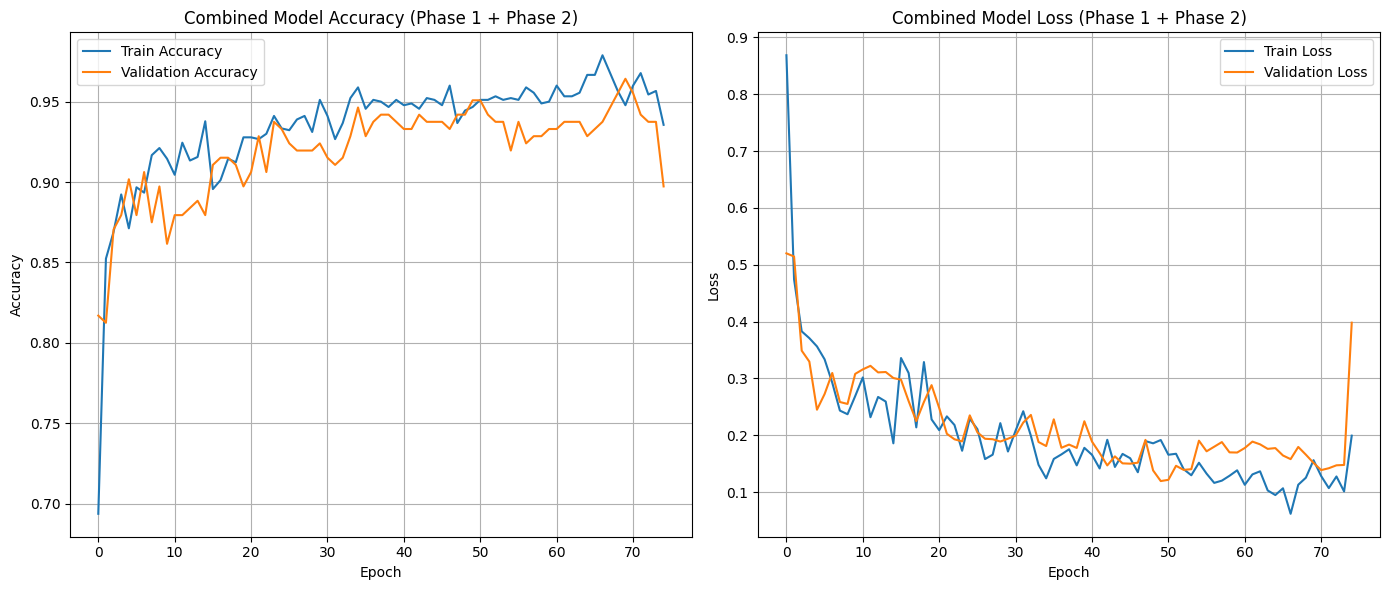

In [ ]:

def plot_combined_history_single_model(history_p1_dict, history_p2_dict):
    combined_history = {}
    for key in history_p1_dict.keys():
        combined_history[key] = history_p1_dict[key] + history_p2_dict[key]

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(combined_history['accuracy'], label='Train Accuracy')
    plt.plot(combined_history['val_accuracy'], label='Validation Accuracy')
    plt.title('Combined Model Accuracy (Phase 1 + Phase 2)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(combined_history['loss'], label='Train Loss')
    plt.plot(combined_history['val_loss'], label='Validation Loss')
    plt.title('Combined Model Loss (Phase 1 + Phase 2)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example of plotting the history of the LAST trained model
if all_phase1_histories and all_phase2_histories:
    plot_combined_history_single_model(all_phase1_histories[-1], all_phase2_histories[-1])